# Investigating the Indian startup ecosystem

## Business Understanding

### Description
The objective of this project is to analyse the indian start-up investment data over the course of four years (2018-2021).

#### Data Sources
- 2 SQL data sources (2021 & 2020)
- 2 CSV files (2019 & 2018)

### Null Hypothesis 
Investment amounts received by start-ups have no relation to sectors they operate in.


### Alternate Hypothesis
There is a relationship between investment amounts received by start-ups and the sectors they operate in

### Analytical Questions
1. Does location of headquarters affect the amount of funding or investments?
2. What is the average funding needed per Sector/Category of start up affect the fundings?
3. How many companies are in the different sectors of funding ?
4. Which stages give out the highest investment amounts?
5. Which cities have the highest number of startups and at what levels?
6. What is the average amount of funding startups receive per year?
7. Year of establishment as against average investment in its year of funding

In [159]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from scipy import stats   
from scipy.stats import kruskal
from dotenv import dotenv_values 
import pandas as pd
import seaborn as sns
import warnings 


In [160]:
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')



## Data Understanding



#### Connecting to the dapDB to extract the 2020 and 2021 data

In [161]:
#Connecting to the database to analyse the 2020-2021 data

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [162]:
#query the 2020 startup funding data

query = "SELECT * FROM LP1_startup_funding2020"

data_2020 = pd.read_sql(query, connection)
data_2020.columns

C:\Users\chrap\AppData\Local\Temp\ipykernel_23056\2739378453.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_2020 = pd.read_sql(query, connection)


Index(['Company_Brand', 'Founded', 'HeadQuarter', 'Sector', 'What_it_does',
       'Founders', 'Investor', 'Amount', 'Stage', 'column10'],
      dtype='object')

In [163]:
#Including the investment year to the data
data_2020['Investment_year'] = '2020'
data_2020=data_2020.reset_index()

In [164]:
#Checking the datatypes of the columns
datatypes = data_2020.dtypes
datatypes

index                int64
Company_Brand       object
Founded            float64
HeadQuarter         object
Sector              object
What_it_does        object
Founders            object
Investor            object
Amount             float64
Stage               object
column10            object
Investment_year     object
dtype: object

In [165]:
#query the 2021 startup funding data
query = "SELECT * FROM LP1_startup_funding2021"

data_2021 = pd.read_sql(query, connection)
data_2021.head(5)


C:\Users\chrap\AppData\Local\Temp\ipykernel_23056\3538229512.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_2021 = pd.read_sql(query, connection)


,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage
0,Unbox Robotics,"$2,019.00",Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First","$1,200,000",Pre-series A
1,upGrad,"$2,015.00",Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management","$120,000,000",None
2,Lead School,"$2,012.00",Mumbai,EdTech,LEAD School offers technology based school tra...,"Smita Deorah, Sumeet Mehta","GSV Ventures, Westbridge Capital","$30,000,000",Series D
3,Bizongo,"$2,015.00",Mumbai,B2B E-commerce,Bizongo is a business-to-business online marke...,"Aniket Deb, Ankit Tomar, Sachin Agrawal","CDC Group, IDG Capital","$51,000,000",Series C
4,FypMoney,"$2,021.00",Gurugram,FinTech,"FypMoney is Digital NEO Bank for Teenagers, em...",Kapil Banwari,"Liberatha Kallat, Mukesh Yadav, Dinesh Nagpal","$2,000,000",Seed


In [166]:
#Checking the datatypes of the columns
datatypes = data_2021.dtypes
datatypes

Company_Brand     object
Founded          float64
HeadQuarter       object
Sector            object
What_it_does      object
Founders          object
Investor          object
Amount            object
Stage             object
dtype: object

In [167]:
#Currency Converter function
def curr_converter(df,rate):
    amount_new=[]
    for a in df:
        if a.startswith('$'):
            
            amount_new.append(a.split('$')[1].replace(',',''))
        elif a.startswith('₹'): 
            
            amount_new.append(float((a.split('₹')[1]).replace(',',''))/rate )  
        else :
            amount_new.append(a)    
    return amount_new

In [168]:
#Removing the dollar sign from data
data_2021[data_2021['Amount'].str.contains('$', na = False)]
data_2021['Amount']=data_2021.Amount.str.replace('\W', '', regex=True)


In [169]:
data_2021['Founded'] = data_2021['Founded'].astype(str)
data_2021.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",1200000,Pre-series A
1,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",120000000,None


#### Realised that 2021 data had data entry errors whereby there was a mixup in inputing the data for the Investor,Amount and then the Stage columns

In [170]:
#combining the Stage and Amount columns since there are mixed data entry errors
data_2021['new'] =  data_2021['Investor'].fillna('inv') +data_2021['Amount'].astype(str) + data_2021['Stage'].fillna('ab') 



In [171]:
#Extract the amounts in the combined column to get the new amount column
data_2021['Amount_new']=data_2021['new'].str.extract('(\d+)')
data_2021.head(1)


,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Amount,Stage,new,Amount_new
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",1200000,Pre-series A,"BEENEXT, Entrepreneur First1200000Pre-series A",1200000


In [172]:

data_2021.drop(['new','Amount'], axis =1,inplace=True)
data_2021['Investment_year'] = '2021'

In [173]:
#Renaming the Amount_new column
data_2021.rename(columns={'Amount_new':'Amount'}, inplace=True)
data_2021=data_2021.reset_index()

#2021 data cleaned!!!!!!!!!!!

In [174]:
data_2021.head(1)

,index,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year
0,0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021


In [175]:
#Reading 2018 data from the csv files

data_2018=pd.read_csv('startup_funding_2018_2019\startup_funding2018.csv')
data_2018.head(5)

,Company Name,Industry,Round/Series,Amount,Location,About Company
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...


In [176]:
#Renaming column names of 2018 data to match all other datasets
data_2018.rename(columns={'Company Name':'Company_Brand','Industry':'Sector', 'Round/Series':'Stage', 'Location':'HeadQuarter', 'About Company':'What_it_does'}, inplace=True)
data_2018.head(5)

,Company_Brand,Sector,Stage,Amount,HeadQuarter,What_it_does
0,TheCollegeFever,"Brand Marketing, Event Promotion, Marketing, S...",Seed,250000,"Bangalore, Karnataka, India","TheCollegeFever is a hub for fun, fiesta and f..."
1,Happy Cow Dairy,"Agriculture, Farming",Seed,"₹40,000,000","Mumbai, Maharashtra, India",A startup which aggregates milk from dairy far...
2,MyLoanCare,"Credit, Financial Services, Lending, Marketplace",Series A,"₹65,000,000","Gurgaon, Haryana, India",Leading Online Loans Marketplace in India
3,PayMe India,"Financial Services, FinTech",Angel,2000000,"Noida, Uttar Pradesh, India",PayMe India is an innovative FinTech organizat...
4,Eunimart,"E-Commerce Platforms, Retail, SaaS",Seed,—,"Hyderabad, Andhra Pradesh, India",Eunimart is a one stop solution for merchants ...


In [177]:
#Removing the Lahk symbol and converting the Rupees to dollars
exch_rate= 158.38
amount_list=data_2018.Amount.tolist()
amount_new=curr_converter(amount_list,exch_rate)
data_2018['Amount']=amount_new
data_2018['Investment_year'] = '2018'
data_2018=data_2018.reset_index()

In [178]:
#Reading 2019 data from the csv files
data_2019=pd.read_csv('startup_funding_2018_2019\startup_funding2019.csv')
data_2019['Founded'] = data_2019['Founded'].astype(str)
data_2019.head(5)

,Company/Brand,Founded,HeadQuarter,Sector,What it does,Founders,Investor,Amount($),Stage
0,Bombay Shaving,nan,NaN,Ecommerce,Provides a range of male grooming products,Shantanu Deshpande,Sixth Sense Ventures,"$6,300,000",NaN
1,Ruangguru,2014.0,Mumbai,Edtech,A learning platform that provides topic-based ...,"Adamas Belva Syah Devara, Iman Usman.",General Atlantic,"$150,000,000",Series C
2,Eduisfun,nan,Mumbai,Edtech,It aims to make learning fun via games.,Jatin Solanki,"Deepak Parekh, Amitabh Bachchan, Piyush Pandey","$28,000,000",Fresh funding
3,HomeLane,2014.0,Chennai,Interior design,Provides interior designing solutions,"Srikanth Iyer, Rama Harinath","Evolvence India Fund (EIF), Pidilite Group, FJ...","$30,000,000",Series D
4,Nu Genes,2004.0,Telangana,AgriTech,"It is a seed company engaged in production, pr...",Narayana Reddy Punyala,Innovation in Food and Agriculture (IFA),"$6,000,000",NaN


In [179]:
#Renaming column names of 2019 data to match all other datasets
data_2019.rename(columns={'Company/Brand':'Company_Brand', 'What it does':'What_it_does', 'Amount($)':'Amount'}, inplace=True)
data_2019.columns


Index(['Company_Brand', 'Founded', 'HeadQuarter', 'Sector', 'What_it_does',
       'Founders', 'Investor', 'Amount', 'Stage'],
      dtype='object')

In [180]:
#Removing the Lahk symbol and converting the Rupees to dollars
exch_rate= 177.13
amount_list=data_2019.Amount.tolist()
amount_new=curr_converter(amount_list,exch_rate)
data_2019['Amount']=amount_new
data_2019['Investment_year'] = '2019'
#data_2019=data_2019.reset_index()

### Merging datasets

In [181]:
#Concating the four datasets since they have a similar structure to one big data
pd.set_option('display.max_rows', None)
final_df = pd.concat([data_2021,data_2020,data_2019,data_2018],axis=0,ignore_index=True)
final_df.head(5)


,index,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,column10
0,$0.00,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021,NaN
1,$1.00,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",None,120000000,2021,NaN
2,$2.00,Lead School,2012.0,Mumbai,EdTech,LEAD School offers technology based school tra...,"Smita Deorah, Sumeet Mehta","GSV Ventures, Westbridge Capital",Series D,30000000,2021,NaN
3,$3.00,Bizongo,2015.0,Mumbai,B2B E-commerce,Bizongo is a business-to-business online marke...,"Aniket Deb, Ankit Tomar, Sachin Agrawal","CDC Group, IDG Capital",Series C,51000000,2021,NaN
4,$4.00,FypMoney,2021.0,Gurugram,FinTech,"FypMoney is Digital NEO Bank for Teenagers, em...",Kapil Banwari,"Liberatha Kallat, Mukesh Yadav, Dinesh Nagpal",Seed,2000000,2021,NaN


In [182]:
#Saving the combined dataset to xlsx
#final_df.to_csv("startup_funding_2018_2019\combined.csv",index=False
#             ) 

# Data Exploration

In [183]:
df= final_df
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            2790 non-null   float64
 1   Company_Brand    2879 non-null   object 
 2   Founded          2140 non-null   object 
 3   HeadQuarter      2765 non-null   object 
 4   Sector           2861 non-null   object 
 5   What_it_does     2879 non-null   object 
 6   Founders         2334 non-null   object 
 7   Investor         2253 non-null   object 
 8   Stage            1941 non-null   object 
 9   Amount           2494 non-null   object 
 10  Investment_year  2879 non-null   object 
 11  column10         2 non-null      object 
dtypes: float64(1), object(11)
memory usage: 270.0+ KB


,index,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,column10
0,$0.00,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021,NaN
1,$1.00,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",None,120000000,2021,NaN


In [184]:
df.shape
df['HeadQuarter'].unique()

array(['Bangalore', 'Mumbai', 'Gurugram', 'New Delhi', 'Hyderabad',
       'Jaipur', 'Ahmadabad', 'Chennai', None,
       'Small Towns, Andhra Pradesh', 'Goa', 'Rajsamand', 'Ranchi',
       'Faridabad, Haryana', 'Gujarat', 'Pune', 'Thane', 'Computer Games',
       'Cochin', 'Noida', 'Chandigarh', 'Gurgaon', 'Vadodara',
       'Food & Beverages', 'Pharmaceuticals\t#REF!', 'Gurugram\t#REF!',
       'Kolkata', 'Ahmedabad', 'Mohali', 'Haryana', 'Indore', 'Powai',
       'Ghaziabad', 'Nagpur', 'West Bengal', 'Patna', 'Samsitpur',
       'Lucknow', 'Telangana', 'Silvassa', 'Thiruvananthapuram',
       'Faridabad', 'Roorkee', 'Ambernath', 'Panchkula', 'Surat',
       'Coimbatore', 'Andheri', 'Mangalore', 'Telugana', 'Bhubaneswar',
       'Kottayam', 'Beijing', 'Panaji', 'Satara', 'Orissia', 'Jodhpur',
       'New York', 'Santra', 'Mountain View, CA', 'Trivandrum',
       'Jharkhand', 'Kanpur', 'Bhilwara', 'Guwahati',
       'Online Media\t#REF!', 'Kochi', 'London',
       'Information Technol

In [185]:
#split HQ column into Town,City and Country columns
df[['Town', 'City','Country']] = df['HeadQuarter'].str.split(',', expand=True)
#df.head(2)


In [186]:
# Function to fill new column based on conditions
def fill_new_column(row):
    if row['Town'] != '':
        return row['Town']
    else:
        return row['City']
    
# Create a new column filled with values from one column or default value if empty
df['Headquarter_City'] = df.apply(fill_new_column, axis=1)    

#df.head(2)

In [187]:
#Correct a few of the misspelled names
hq = df.Headquarter_City.tolist()
hq_cat=[]
hq_cat = ['Ahmedabad' if 'ahmedabad' in str(a).lower()  or 'ahmadabad' in str(a).lower()
         else 'Bangalore' if 'bangalore' in str(a).lower() 
         else 'Uttar Pradesh' if 'pradesh' in str(a).lower() 
         else 'Gurugram' if 'gurugram' in str(a).lower() 
         else 'Bangalore' if 'banglo' in str(a).lower() 
         else 'Hyderabad' if 'hyderebad' in str(a).lower() or 'hyderabad' in str(a).lower()
         else a
         for a in hq]
hq_cat
df['Headquarter_City']=hq_cat

#### Categorising the Sectors into 9 groups for easier classification
- Technology & Software: Startups primarily focused on developing software, AI, IT solutions, and technology-related services.
- E-commerce & Retail: Startups involved in online retail, e-commerce platforms, marketplace solutions, and retail-focused businesses.
- Finance & FinTech: Startups operating in financial services, banking, financial technology (FinTech), cryptocurrency, and related areas.
- Healthcare & HealthTech: Startups in the healthcare industry, including health technology (HealthTech), telemedicine, medical devices, and healthcare services.
- Education: Startups in the Education industry, including learning,spacetech,data story telling and edtech.
- Energy: Startups in the Energy industry, including Renewable energy,battery technology, EV systems, crude oil and other energy related services.
- Agriculture: Startups in the Agriclture industry, including farming and fishing.
- Hospitality: Startups in the Hospitality industry, including real estate,hotels,homes and hospitality services.
- Others: Startups that do not fit directly into the above categories or have unique business models.


In [188]:
#Categorizing the startups into 9 groups
sector = df.Sector.tolist()
cat=[]
cat = ['Finance & FinTech' if 'bank' in str(a).lower() or 'trading' in str(a).lower() or 'fintech' in str(a).lower() or 'vent' in str(a).lower() or 'capital' in str(a).lower() or 'insure' in str(a).lower() or 'crypt' in str(a).lower() or 'nft' in str(a).lower() or 'equity' in str(a).lower()
         else 'Technology & Software' if 'ai startup' in str(a).lower() or 'it' in str(a).lower() or 'chain' in str(a).lower() or 'augment' in str(a).lower() or 'robot' in str(a).lower() or 'gamin' in str(a).lower() or 'information' in str(a).lower() or 'mobile' in str(a).lower() or 'mlops' in str(a).lower() or 'biotech' in str(a).lower() or 'space' in str(a).lower() or 'nano' in str(a).lower()
         else 'E-commerce & Retail' if 'b2b' in str(a).lower() or 'e-com' in str(a).lower() or 'reta' in str(a).lower() or 'soci' in str(a).lower() or 'food' in str(a).lower() or 'content' in str(a).lower() or 'decor' in str(a).lower() or 'electronics' in str(a).lower() or 'apparel' in str(a).lower() or 'fashion' in str(a).lower() or 'food' in str(a).lower() or  'eye' in str(a).lower() or 'merchand' in str(a).lower()
         else 'Education' if 'edtech' in str(a).lower() or 'learn' in str(a).lower() or 'working' in str(a).lower() or 'story' in str(a).lower()  or 'edcation' in str(a).lower() or 'engineering' in str(a).lower()
         else 'Healthcare & HealthTech' if 'heal' in str(a).lower() or 'medi' in str(a).lower() or 'care' in str(a).lower() or 'hael' in str(a).lower() or 'nutri' in str(a).lower()
         else 'Agriculture' if 'farm' in str(a).lower() or 'fish' in str(a).lower() or 'annabi' in str(a).lower() or 'pollution' in str(a).lower()
         else 'Energy' if 'energy' in str(a).lower() or 'petro' in str(a).lower() or 'crude' in str(a).lower() or 'batter' in str(a).lower() or 'ev start' in str(a).lower() or 'solar' in str(a).lower() or 'ev' in str(a).lower()
         else 'Hospitality' if 'hospitalit' in str(a).lower() or 'mortg' in str(a).lower() or 'estate' in str(a).lower() or 'touri' in str(a).lower()
         else 'Other'
         for a in sector]


#### Categorizing the Stages
Categorizing the Stages into the 8 known groups of startup funding. Though there are other ways of funding such as debt financing ,IPO, etc there are eight (8) known groups of startup funding which are the seed funding and the other seven (7) in series from A to G.

In [189]:
#Categorizing the Stages into the 9 known groups of startup funding 
stages = df.Stage.tolist()
stage=[]
stage = ['Series A' if 'series a' in str(a).lower() 
         else 'Series B' if 'series b' in str(a).lower() 
         else 'Series C' if 'series c' in str(a).lower()
         else 'Series D' if 'series d' in str(a).lower() 
         else 'Series E' if 'series e' in str(a).lower() 
         else 'Series F' if 'series f' in str(a).lower() 
         else 'Series G' if 'series g' in str(a).lower() 
         else 'Seed' if 'seed' in str(a).lower() 
         else 'Other'
         for a in stages]

In [190]:
#Adding the category and categorised stages to the dataset
df['Category']=cat
df['Categorised_stage']=stage

In [191]:
df.head(2)

,index,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,column10,Town,City,Country,Headquarter_City,Category,Categorised_stage
0,$0.00,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,1200000,2021,NaN,Bangalore,None,None,Bangalore,Technology & Software,Series A
1,$1.00,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",None,120000000,2021,NaN,Mumbai,None,None,Mumbai,Education,Other


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2879 entries, 0 to 2878
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2790 non-null   float64
 1   Company_Brand      2879 non-null   object 
 2   Founded            2140 non-null   object 
 3   HeadQuarter        2765 non-null   object 
 4   Sector             2861 non-null   object 
 5   What_it_does       2879 non-null   object 
 6   Founders           2334 non-null   object 
 7   Investor           2253 non-null   object 
 8   Stage              1941 non-null   object 
 9   Amount             2494 non-null   object 
 10  Investment_year    2879 non-null   object 
 11  column10           2 non-null      object 
 12  Town               2765 non-null   object 
 13  City               560 non-null    object 
 14  Country            540 non-null    object 
 15  Headquarter_City   2765 non-null   object 
 16  Category           2879 

In [193]:
#Dropping the Town,Other,City and column10 columns 
df.drop(['index','Town','Country','City','column10'],axis =1,inplace=True)

In [194]:
#Converting the Amount column to numeric
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')


In [195]:
df.Category.unique()
df.head(1)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,"$1,200,000.00",2021,Bangalore,Technology & Software,Series A


#### Filling the empty Amount rows
- Since investments made for startups can not be zero, we are replacing the 'nan' with the median investment of the sector that the startup finds itself in.
- Since investments made for startups are not less than $1000, we are replacing these rows with the average investment of the sector that the startup finds itself in.

In [196]:
# Finding the medians of the respective category
cat_median_dict={}
for cat in df.Category.unique():
    cat_median_dict[cat] = df[df.Category == cat].Amount.median()

cat_median_dict

{'Technology & Software': 2055000.0,
 'Education': 2000000.0,
 'E-commerce & Retail': 4000000.0,
 'Finance & FinTech': 5185500.0,
 'Other': 2000000.0,
 'Healthcare & HealthTech': 2550000.0,
 'Energy': 2000000.0,
 'Hospitality': 2050000.0,
 'Agriculture': 2000000.0}

In [197]:
# Finding the averages of the respective category
cat_average_dict={}
for cat in df.Category.unique():
    cat_average_dict[cat] = df[df.Category == cat].Amount.mean()

cat_average_dict

{'Technology & Software': 18367619.888364002,
 'Education': 32298670.270391848,
 'E-commerce & Retail': 63950346805.5086,
 'Finance & FinTech': 536755019.733096,
 'Other': 29459190.50164511,
 'Healthcare & HealthTech': 16561045.623498881,
 'Energy': 23012981.731940795,
 'Hospitality': 7068740.444444444,
 'Agriculture': 4056569.6426316453}

In [198]:
#Filling the nan Amount values  with their respective averages of their respective category
index_list = df.query("Amount == 'nan'").index.tolist()
for nums in index_list:
    cat=df.iloc[nums].Category
    old=df.iloc[nums].Amount
    df.replace(old,cat_average_dict[cat],inplace=True)

In [199]:
#Fill nan with their respective medians of their respective category
index_list = df.query("Amount == 'nan'").index.tolist()
for nums in index_list:
    cat=df.iloc[nums].Category
    old=df.iloc[nums].Amount
    df.replace(old,cat_median_dict[cat],inplace=True)


In [200]:
# Find nulls using .isnull()
df=df.replace(r'^s*$', float('NaN'), regex = True)

In [201]:
# Sum of nulls using .isna()
df.isna().sum()

Company_Brand          0
Founded              739
HeadQuarter          114
Sector                18
What_it_does           0
Founders             545
Investor             626
Stage                938
Amount               545
Investment_year        0
Headquarter_City     114
Category               0
Categorised_stage      0
dtype: int64

In [202]:
df.dropna(subset = ['Amount'], inplace = True) 

In [203]:
#finding duplicates
duplicate = df[df.duplicated()]
duplicate.shape

(21, 13)

#### OBSERVATION
- There are 21 duplicates in the dataset

In [204]:
#Dropping the duplicates
df.drop_duplicates()
df.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,"$1,200,000.00",2021,Bangalore,Technology & Software,Series A
1,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",None,"$120,000,000.00",2021,Mumbai,Education,Other


In [205]:
#Converting the Amount column to numeric
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,"$2,334.00","$8,689,203,248.22","$413,991,936,207.24",$1.00,"$700,000.00","$2,940,000.00","$11,000,000.00","$20,000,002,000,000.00"


In [206]:
### Only india cities

indian_cities=['Bangalore', 'Mumbai','Gurugram', 'New Delhi','Hyderabad','Jaipur', 'Ahmedabad', 'Chennai','Goa','Rajsamand','Ranchi','Faridabad', 'Gujarat','Thane','Pune','Cochin',
 'Noida', 'Chandigarh','Gurgaon','Vadodara','Kolkata', 'Haryana','Indore','Powai','Ghaziabad','Nagpur','West Bengal','Patna','Samsitpur','Lucknow','Telangana','Silvassa', 'Ambernath',
 'Panchkula','Surat', 'Andheri','Telugana','Bhubaneswar','Kottayam', 'Panaji','Coimbatore','Satara',
 'Orissia','Jodhpur','Santra','Trivandrum','Bhilwara','Kochi', 'The Nilgiris','Gandhinagar', 'Belgaum','Tirunelveli','Delhi', 'Dhingsara',
 'Bangaldesh','Samastipur','Rajastan','Ludhiana','Dehradun',
 'Kanpur','Odisha','Bihar','Uttar Pradesh','Banglore', 'Rajasthan','Bengaluru','Kalkaji','India',
 'Kota','Margão','Kannur','Kormangala','Mylapore','Guntur','Kalpakkam','Bhopal','Alleppey','Guindy']



df=df[df['Headquarter_City'].isin(indian_cities)]


In [207]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.10f" % p_value_normality)
    if p_value_normality <0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [208]:
fintech=df[df.Category=='Finance & FinTech']
tech = df[df.Category=='Technology & Software']
commerce=df[df.Category=='E-commerce & Retail']
health=df[df.Category=='Healthcare & HealthTech']
edu=df[df.Category=='Education']
agric = df[df.Category=='Agriculture']
energy = df[df.Category == 'Energy']
other=df[df.Category=='Other']


In [209]:

check_normality(fintech.Amount,'Finance & FinTech')
check_normality(tech.Amount,'Technology & Software')
check_normality(commerce.Amount,'E-commerce & Retail')
check_normality(health.Amount,'Healthcare & HealthTech')
check_normality(edu.Amount,'Education')
check_normality(agric.Amount,'Agriculture')
check_normality(energy.Amount,'Energy')
check_normality(other.Amount,'Other')


p value:0.0000000000
Reject null hypothesis >> The data for Finance & FinTech is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for Technology & Software is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for E-commerce & Retail is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for Healthcare & HealthTech is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for Education is not normally distributed
p value:0.0282336939
Reject null hypothesis >> The data for Agriculture is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for Energy is not normally distributed
p value:0.0000000000
Reject null hypothesis >> The data for Other is not normally distributed


In [210]:
#Use an ANOVA test (READ ABOUT IT) (Non parametric tests)
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(fintech.Amount, commerce.Amount, health.Amount,tech.Amount,edu.Amount,agric.Amount,energy.Amount,other.Amount)

print("p value:%.4f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.5223
Fail to reject null hypothesis >> The variances of the samples are same.


#### OBSERVATION
- Though the variances of the samples are the same thereby satisifying the homogeneity of variance,the distribution of the samples differ therefore the data calls for a non-parametric test on its hypothesis.
- Using ANOVA to test the hypothesis will introduce a significant level of error. 
- Conducting a non-parametric test will be ideal (the Kruskal-Wallis test).

In [211]:

stat, p = kruskal(fintech.Amount, commerce.Amount, health.Amount,tech.Amount,edu.Amount,agric.Amount,energy.Amount,other.Amount)
print('Statistics=%.3f, p=%.10f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=48.664, p=0.0000000264
One or more sample distributions are not equal distributions (reject null Hypothesis)


### Analytical Questions

In [212]:
df.head(2)

,Company_Brand,Founded,HeadQuarter,Sector,What_it_does,Founders,Investor,Stage,Amount,Investment_year,Headquarter_City,Category,Categorised_stage
0,Unbox Robotics,2019.0,Bangalore,AI startup,Unbox Robotics builds on-demand AI-driven ware...,"Pramod Ghadge, Shahid Memon","BEENEXT, Entrepreneur First",Pre-series A,"$1,200,000.00",2021,Bangalore,Technology & Software,Series A
1,upGrad,2015.0,Mumbai,EdTech,UpGrad is an online higher education platform.,"Mayank Kumar, Phalgun Kompalli, Ravijot Chugh,...","Unilazer Ventures, IIFL Asset Management",None,"$120,000,000.00",2021,Mumbai,Education,Other


In [213]:
#Converting Amount to millions of dollars
df['Amount']=df.Amount/1000000
pd.options.display.float_format = '${:,.2f}'.format

In [ ]:
#Saving the combined dataset to xlsx
final_df.to_csv("startup_funding_2018_2019\combined.csv",index=False
            )

#### Observation
Level of confidence in startups by investors

#### 1. Does location of headquarters affect the amount of funding or investments?

In [228]:
startup_loc= df.groupby('Headquarter_City')['Amount'].mean().sort_values(ascending=False).head(10)

startup_loc

Headquarter_City
Gurugram      $94,375.37
Mumbai           $597.02
Kalpakkam        $210.00
Faridabad         $82.20
Haryana           $35.63
Bangalore         $33.85
Rajasthan         $33.00
Guindy            $30.00
Bhubaneswar       $30.00
Patna             $30.00
Name: Amount, dtype: float64

<AxesSubplot:title={'center':'Top Ten Average Investments per Headquarter Locations'}, xlabel='Headquarter_City'>

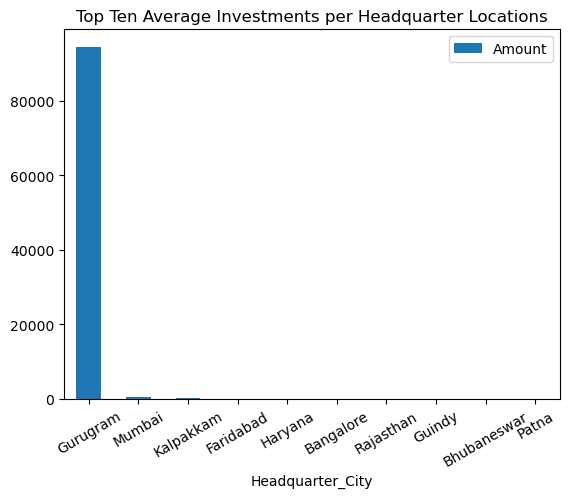

In [229]:
startup_loc.plot(kind="bar",title='Top Ten Average Investments per Headquarter Locations', legend=True,rot=30,y='Millions of Dollars')


#### Observation
Gurugram is a business tech hub in the center 


#### 2. What is the average funding needed per Sector/Category of start up affect the fundings?

In [237]:
####Make the necessary changes
startup_cat= df.groupby('Category')['Amount'].mean().sort_values(ascending=False)
startup_cat

Category
E-commerce & Retail       $65,836.62
Finance & FinTech            $567.13
Education                     $28.44
Other                         $26.02
Energy                        $21.35
Technology & Software         $18.21
Healthcare & HealthTech       $16.00
Hospitality                    $7.07
Agriculture                    $4.06
Name: Amount, dtype: float64

<AxesSubplot:title={'center':'Average Investments recorded per Category'}, xlabel='Category'>

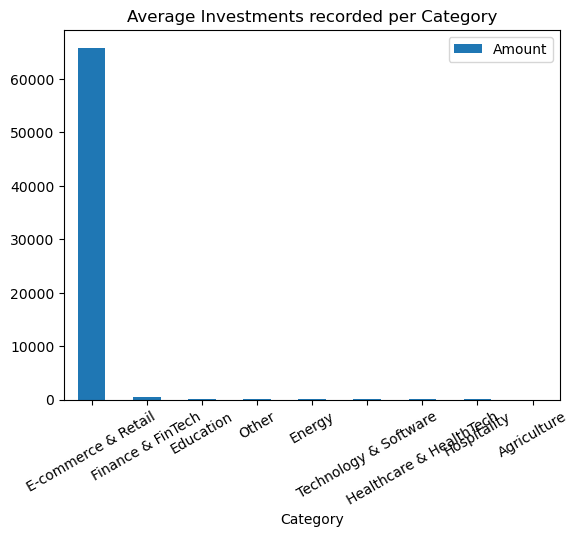

In [238]:
startup_cat.plot(kind="bar",title='Average Investments recorded per Category', legend=True,rot=30,y='Millions of Dollars')

#### Observation
E-commerce & Retail having the highest average investment shows that this Idustrial Category is vast and booming with a lot of potential. This high average investment shows that there are numerous startups that fall within this category and there is a level of expertise needed to gain a large market share of this very competitve sector.

#### 3. How many companies are in the different sectors of funding ?

In [218]:
startup_stages= df.groupby(['Categorised_stage'])['Category'].count().sort_values(ascending=False)
startup_stages

Categorised_stage
Other       816
Seed        528
Series A    506
Series B    139
Series C    106
Series D     52
Series E     30
Series F     11
Series G      3
Name: Category, dtype: int64

<AxesSubplot:title={'center':'Number of companies in the different funding sectors'}, xlabel='Categorised_stage'>

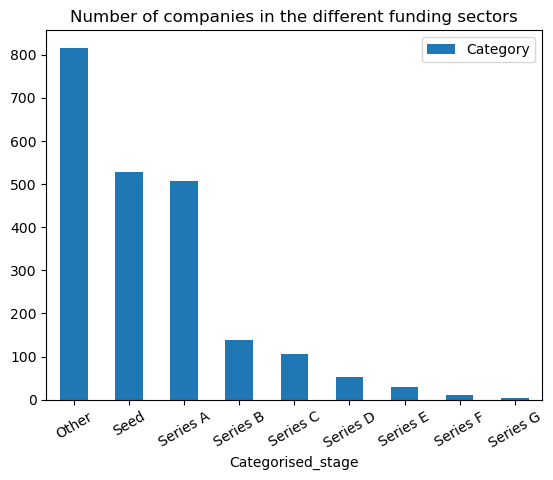

In [219]:
startup_stages.plot(kind="bar",title='Number of companies in the different funding sectors', legend=True,rot=30,y='Millions of Dollars')

#### Observation
This graph ultimately shows that there is a lot of untapped investments in the startups in India. With almost 800 companies looking other sources of funding such as loans and debt financing, investors can give startups lower rates to not only get a good return on investment but also own a part of the startup company.

#### 4. Which stages give out the highest investment amounts?

In [230]:
startup_sectors= df.groupby('Categorised_stage')['Amount'].mean().sort_values(ascending=False)
startup_sectors

Categorised_stage
Series A   $39,531.97
Series F      $330.93
Other         $305.87
Series G      $197.67
Series E      $114.55
Series D       $68.43
Series C       $48.30
Series B       $24.44
Seed            $1.79
Name: Amount, dtype: float64

<AxesSubplot:title={'center':'Average investment per funding sectors'}, xlabel='Categorised_stage'>

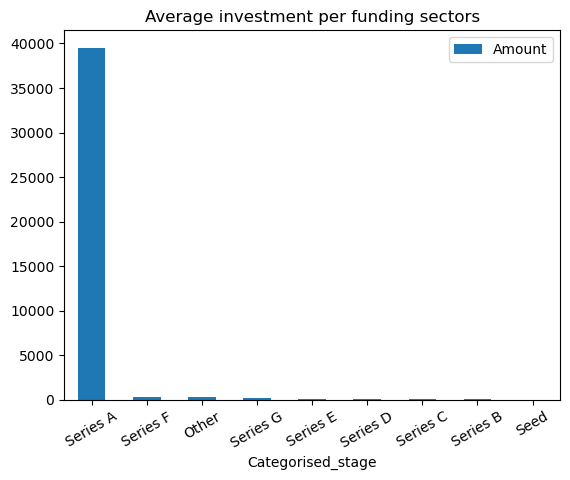

In [248]:
startup_sectors.plot(kind="bar",title='Average investment per funding sectors', legend=True,rot=30,y='Millions of Dollars')

#### Observation
Most investors are more comfortable with startups that have a track record of recieving funds and are able to account for all monies spent. Series A sector having the highest number of companies whilst Seed sector holdin the lowest companies is in line with the earlier 

#### 5. Which cities have the highest number of startups and at what levels?

In [244]:
startup_cities= df.groupby(['Headquarter_City','Categorised_stage'])['Categorised_stage'].count().sort_values(ascending=False).head(7)
startup_cities

Headquarter_City  Categorised_stage
Bangalore         Other                248
                  Seed                 167
                  Series A             164
Mumbai            Other                161
                  Seed                  89
                  Series A              81
New Delhi         Other                 79
Name: Categorised_stage, dtype: int64

<AxesSubplot:title={'center':'Number of companies in the different funding sectors'}, xlabel='Headquarter_City,Categorised_stage'>

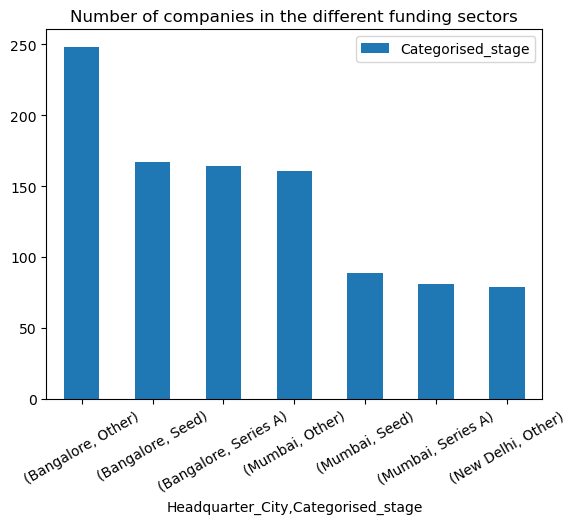

In [245]:
startup_cities.plot(kind="bar",title='Number of companies in the different funding sectors', legend=True,rot=30,y='Millions of Dollars')

#### Observation
Bangalore has the highest number of startups with almost 250 startups funded by other sources such as debt financing, 167 startups in seed funding and 164 startups in Series A funding.

#### 6. What is the average amount of funding startups receive per year?

In [246]:
startup_year= df.groupby('Investment_year')['Amount'].mean().sort_values(ascending=True)
startup_year

Investment_year
2018       $15.71
2019       $42.65
2020      $123.43
2021   $18,930.82
Name: Amount, dtype: float64

<AxesSubplot:title={'center':'Number of companies in the different funding sectors'}, xlabel='Investment_year'>

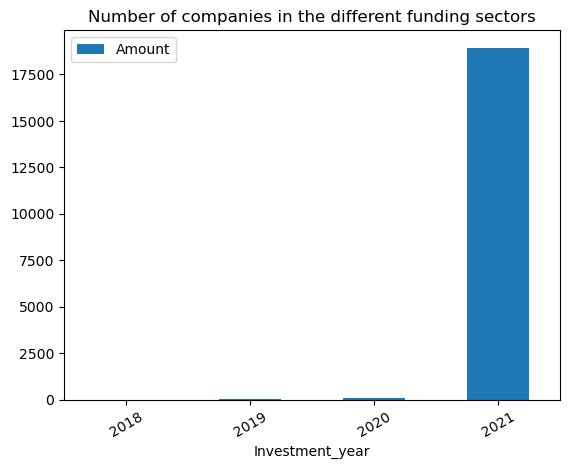

In [247]:
startup_year.plot(kind="bar",title='Number of companies in the different funding sectors', legend=True,rot=30,y='Millions of Dollars')

#### Observation
From the graph,it can be seen that there is an exponentially growing interest in startup funding.

##### 7. What is the level of confidence of startups in investors over the years of establishment

<AxesSubplot:title={'center':'Number of Investments recieved per year of Startup Establishment'}, xlabel='Founded'>

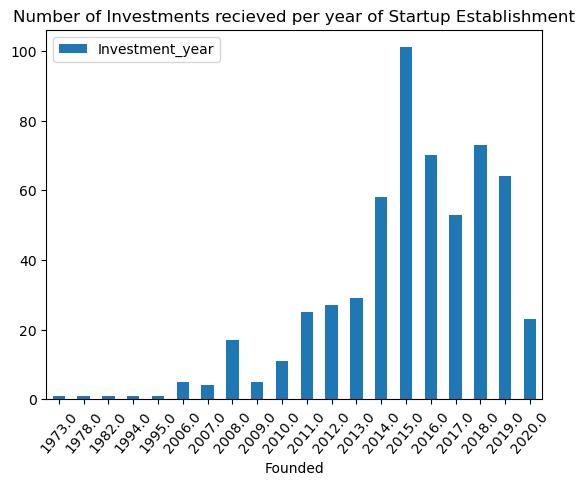

In [226]:
startup_conf= df.groupby(['Founded'])['Investment_year'].count().head(20)
startup_conf.plot(kind="bar",title='Number of Investments recieved per year of Startup Establishment', legend=True,rot=50,y='Millions of Dollars')

#### Observation
From the graph it can be realised that there was a sudden keen interest and confidence in investment funding by startups from 2010 and then interest grew exponentially till 2015. This interest and confidence dwindled from 2016 to 2020 and this can be attributed to the difficulty of finding investors and cost of funding.

#### 8. Year of establishment as against average investment in its year of funding

<AxesSubplot:title={'center':'Top Ten Startups Locations with the Highest Number of Investments'}, xlabel='Founded,Investment_year'>

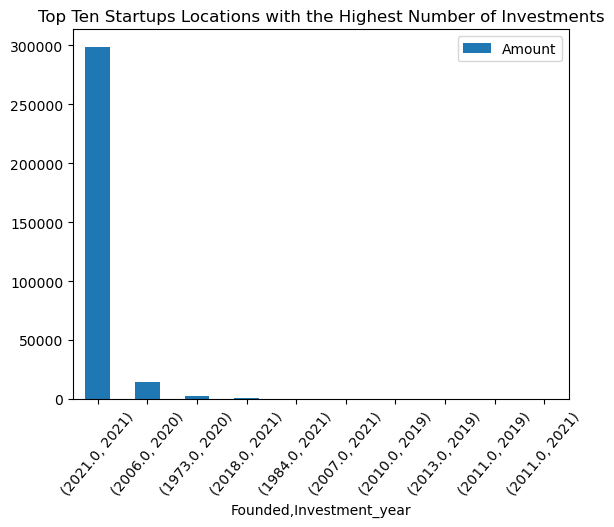

In [227]:
startup_founded= df.groupby(['Founded','Investment_year'])['Amount'].mean().sort_values(ascending=False).head(10)
startup_founded.plot(kind="bar",title='Top Ten Startups Locations with the Highest Number of Investments', legend=True,rot=50,y='Millions of Dollars')

#### Observation
Apart from 2021 being an outlier, one will realise that investors were more aligned to funding startups that have been in operation for more than 7 years.